In [1]:
# Set matplotlib backend
# This has to be done before other importa that might
# set it, but only if we're running in script mode
# rather than being imported.
%matplotlib inline 
import random
import os
import sys
import json
import datetime
import numpy as np
import skimage.io
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

# Results directory
# Save submission files here
RESULTS_DIR = os.path.join(ROOT_DIR, "results/caries/")

# The dataset doesn't have a standard train/val split, so I picked
# a variety of images to surve as a validation set.
VAL_IMAGE_IDS = [
    "0",
    "16",
    "27",
    "34",
    "42",
    "58",
    "64",
    "76",
    "89",
    "95",
    "101",
    "7",
    "12",
    "37",
    "69",
    "81",
    "51",
    "92",
    "29",
    "48",
]


C:\Users\User\Anaconda3\envs\MaskRCNN\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ROOT_DIR

'C:\\Users\\User\\Mask_RCNN'

In [3]:
class CariesConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "caries"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + nucleus

    # Number of training and validation steps per epoch
    STEPS_PER_EPOCH = (103 - len(VAL_IMAGE_IDS)) // IMAGES_PER_GPU
    VALIDATION_STEPS = max(1, len(VAL_IMAGE_IDS) // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_SCALE = 2.0

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 15

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 15
config = CariesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        15
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               15
MEAN_PIXEL                     [43.53 39.56 48.22]
MINI_MASK_SHAPE                (56, 56)
NAME                           caries
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS

In [4]:
dataset_dir='C:/Users/User/Mask_RCNN/samples/Carries/Train'

In [5]:
class CariesDataset(utils.Dataset):

    def load_caries(self, dataset_dir, subset):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("caries", 1, "caries")

        # Which subset?
        # "val": use hard-coded list above
        # "train": use data from stage1_train minus the hard-coded list above
        # else: use the data from the specified sub-directory
        assert subset in ["train", "val", "stage1_train", "stage1_test", "stage2_test"]
        subset_dir = "stage1_train" if subset in ["train", "val"] else subset
        dataset_dir = os.path.join(dataset_dir)
        if subset == "val":
            image_ids = VAL_IMAGE_IDS
        else:
            # Get image ids from directory names
            image_ids = next(os.walk(dataset_dir))[1]
            if subset == "train":
                image_ids = list(set(image_ids) - set(VAL_IMAGE_IDS))

        # Add images
        for image_id in image_ids:
            self.add_image(
                "caries",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id, "Image/{}.png".format(image_id)))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "Mask")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".png"):
                m = skimage.io.imread(os.path.join(mask_dir, f)).astype(np.bool)
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "caries":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
#Preparing Trainig dataset
dataset_train = CariesDataset()
dataset_train.load_caries(dataset_dir,'train')
dataset_train.prepare()


#Preparing Validation dataset
dataset_val = CariesDataset()
dataset_val.load_caries(dataset_dir,'val')
dataset_val.prepare()


In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)

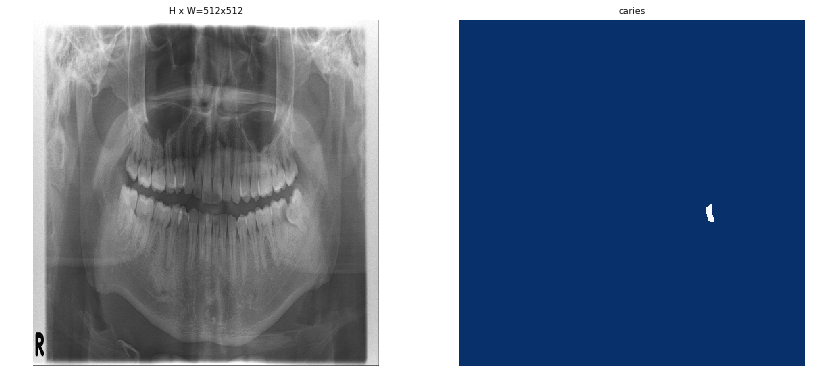

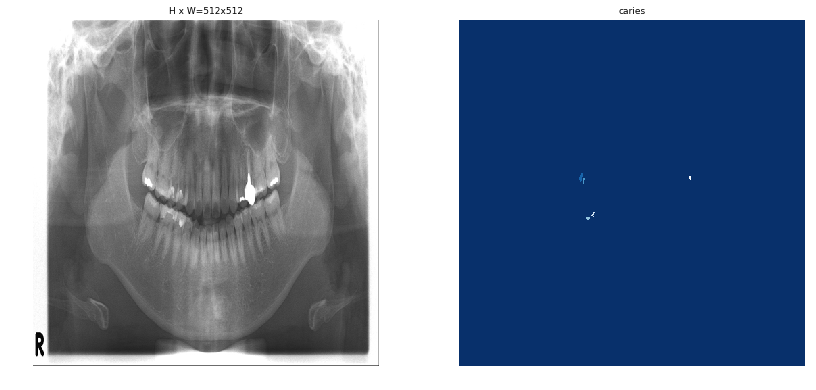

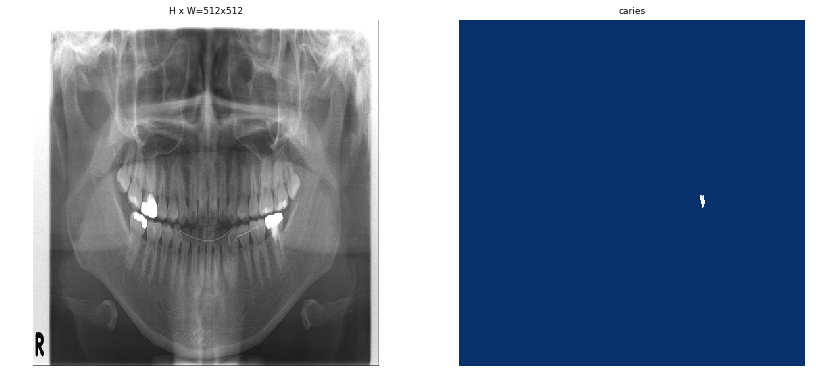

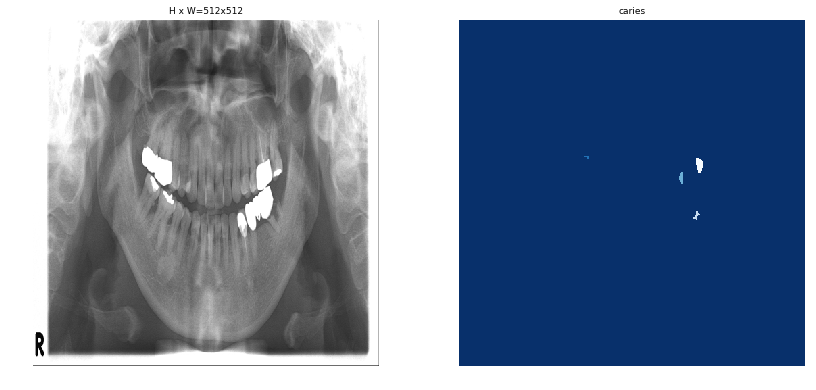

In [8]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [10]:
from imgaug import augmenters as iaa
augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])

In [10]:
# Load dataset
dataset = CariesDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_caries(dataset_dir, subset="train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 83
Class Count: 2
  0. BG                                                
  1. caries                                            


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:  172.00000  max:  351.00000  int32
gt_mask                  shape: (512, 512, 5)         min:    0.00000  max:    1.00000  bool


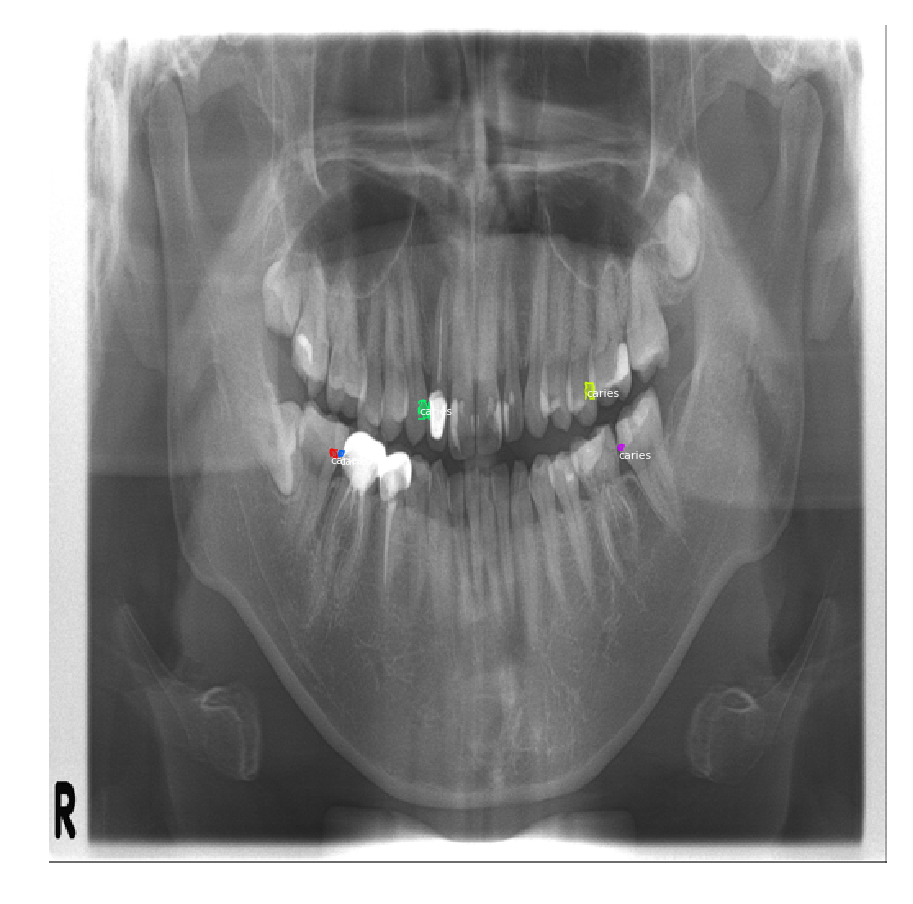

In [11]:
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)
class_name=dataset_train.class_names

# Display image and additional stats
#print("image_id ", image_id, dataset_train.image_reference(image_id))
# Display image and instances
log("original_image", image)
log("gt_class_id", class_ids)
log("gt_bbox", bbox)
log("gt_mask", mask)
visualize.display_instances((image), (bbox), (mask), class_ids,class_name,show_bbox=True)

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/1000,
                epochs=20,
                #augmentation=augmentation,
                layers='heads')

Train network heads

Starting at epoch 0. LR=1e-06

Checkpoint Path: C:\Users\User\Mask_RCNN\logs\caries20180620T0135\mask_rcnn_caries_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeD

Epoch 19/20
83/83 [==============================] - 122s 1s/step - loss: 1.8366 - rpn_class_loss: 0.2060 - rpn_bbox_loss: 1.0262 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.3687 - mrcnn_mask_loss: 0.2110 - val_loss: 1.5509 - val_rpn_class_loss: 0.1389 - val_rpn_bbox_loss: 1.0883 - val_mrcnn_class_loss: 0.0189 - val_mrcnn_bbox_loss: 0.1830 - val_mrcnn_mask_loss: 0.1218
Epoch 20/20
83/83 [==============================] - 121s 1s/step - loss: 1.5497 - rpn_class_loss: 0.2015 - rpn_bbox_loss: 0.9900 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.1497 - val_loss: 1.4113 - val_rpn_class_loss: 0.1163 - val_rpn_bbox_loss: 1.1232 - val_mrcnn_class_loss: 0.0117 - val_mrcnn_bbox_loss: 0.0951 - val_mrcnn_mask_loss: 0.0651


In [14]:
    print("Train network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/1000,
                epochs=40,
                #augmentation=augmentation,
                layers='all')

Train network heads

Starting at epoch 20. LR=1e-06

Checkpoint Path: C:\Users\User\Mask_RCNN\logs\caries20180620T0135\mask_rcnn_caries_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

In [15]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [16]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [17]:
# Create model in inference mode
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [18]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\User\Mask_RCNN\logs\caries20180620T0135\mask_rcnn_caries_0040.h5


image ID: caries.66 (46) 66
Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (512, 512, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   39.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  177.00000  max:  272.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.000
AP @0.55:	 0.000
AP @0.60:	 0.000
AP @0.65:	 0.000
AP @0.70:	 0.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.000


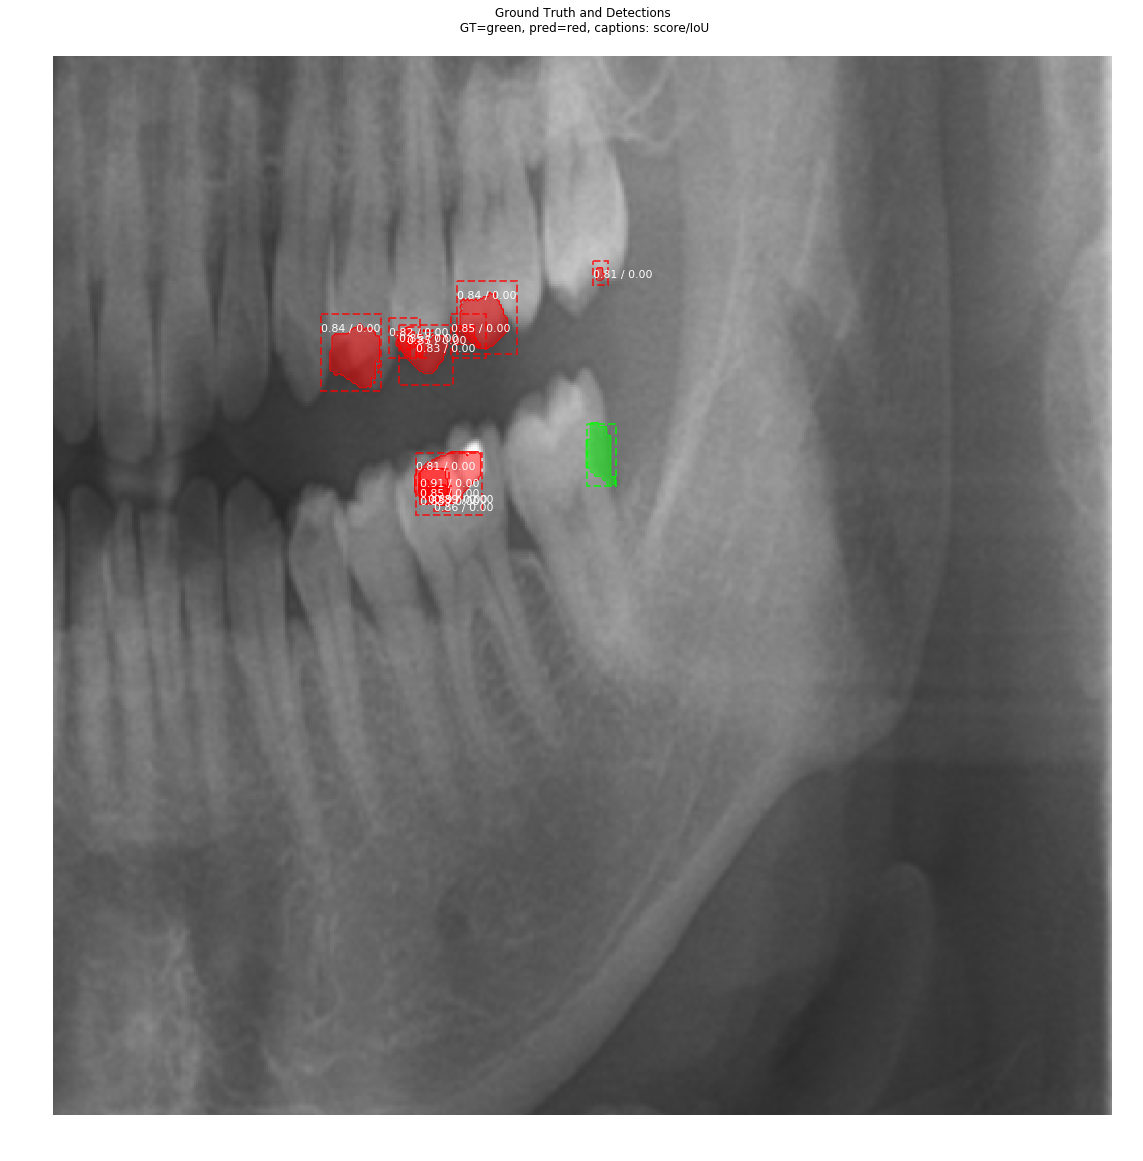

In [24]:
import random
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=True, show_mask=True,
    iou_threshold=0.5, score_threshold=0.5)